# Gaussian Processes

- Different sorts of problems
- Non-parametric

- from finite to infinite dimensions

The bible for Gaussian processes is the Gaussian Processes for
Machines Learning book https://gaussianprocess.org/gpml/chapters/RW.pdf .

From this GPML textbook: A Gaussian process is a collection of random variables,
any finite number of which have a joint Gaussian distribution. In more simplistic terms we can
describe the relationship between any two points using a multivariate Gaussian. Often
you will hear Gaussian processes referred to as non-parametric models, this does not
mean that they do not have parameters, rather, it refers to the fact that the parameters
are not fixed and can change as you include more data. We side-step this by referring to
the parameters as hyperparameters.

A Gaussian processes is typically represented as:

$$
  f(x) \sim \mathcal{GP}(\mu(x), k(x, x'))
$$

where $\mu(x)$ is the mean function and $k(x, x')$ is the covariance function. The
covariance function is called the kernel function and the mean.

Let us go through a simple GP example:

Assume we have two random variables $X_0$ and $X_1$ with the knowledge that $X_1 \sim N(X_0, \sigma)$
with $\sigma = 0.2$. We can generate data about $X_1$ given that we know $X_0$

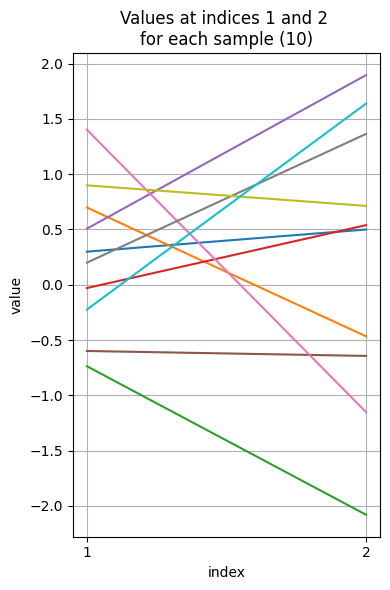

In [1]:
#| code-fold: true

import numpy as np
import matplotlib.pyplot as plt

mean = np.array([0,0])
covariance = np.array([[1, 0.5], [0.5, 1]])
num_samples = 10
data = np.random.multivariate_normal(mean, covariance, num_samples)

index_1 = 1
index_2 = 2
values_1 = data[:, index_1-1]
values_2 = data[:, index_2-1]

plt.figure(figsize=(4, 6))

for i in range(num_samples):
    plt.plot([1, 2], [values_1[i], values_2[i]])

plt.xticks([1, 2], ['1', '2'])  # Set x-axis ticks to only 1 and 2
plt.xlabel('index')
plt.ylabel('value')
plt.title(f'Values at indices 1 and 2 \nfor each sample ({num_samples})')
plt.tight_layout()
plt.grid(True)
plt.show()

As you can see $X_1$ is close to the points given by $X_0$, in fact,
they are normally distributed with a scale parameter of $\sigma = 0.2$.
What happens when we then extend that to another dimension?


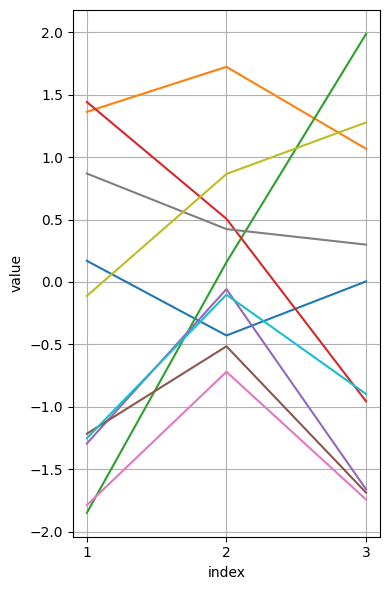

In [5]:
#| code-fold: true

mean = np.array([0,0,0])
covariance = np.array([[1, 0.5, 0.2], [0.5, 1, 0.5], [0.2, 0.5, 1]])
num_samples = 10
data = np.random.multivariate_normal(mean, covariance, num_samples)

index_1 = 1
index_2 = 2
index_3 = 3
values_1 = data[:, index_1-1]
values_2 = data[:, index_2-1]
values_3 = data[:, index_3-1]

plt.figure(figsize=(4, 6))

for i in range(num_samples):
    plt.plot([1, 2, 3], [values_1[i], values_2[i], values_3[i]])

plt.xticks([1, 2, 3], ['1', '2', '3'])  # Set x-axis ticks to only 1 and 2
plt.xlabel('index')
plt.ylabel('value')
plt.tight_layout()
plt.grid(True)
plt.show()

When investigating this plot we can see that the first index is not
very well correlated with the last index, and therefore, knowing about
the first index does not tell us much about the last index. How about changing
these values to something that would be more correlated.

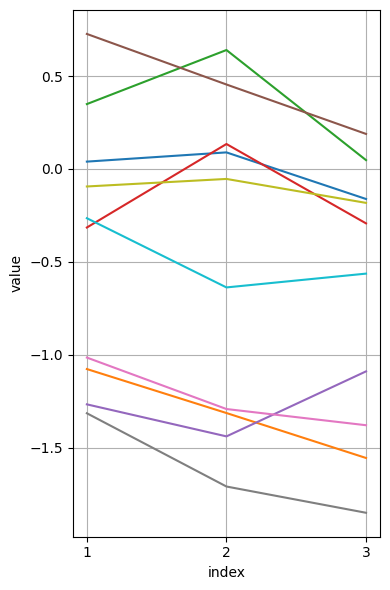

In [6]:
#| code-fold: true

mean = np.array([0,0,0])
covariance_2 = np.array([[1, 0.95, 0.9], [0.95, 1, 0.95], [0.9, 0.95, 1]])
num_samples = 10
data = np.random.multivariate_normal(mean, covariance_2, num_samples)

index_1 = 1
index_2 = 2
index_3 = 3
values_1 = data[:, index_1-1]
values_2 = data[:, index_2-1]
values_3 = data[:, index_3-1]

plt.figure(figsize=(4, 6))

for i in range(num_samples):
    plt.plot([1, 2, 3], [values_1[i], values_2[i], values_3[i]])

plt.xticks([1, 2, 3], ['1', '2', '3'])  # Set x-axis ticks to only 1 and 2
plt.xlabel('index')
plt.ylabel('value')
plt.tight_layout()
plt.grid(True)
plt.show()

We can see with these points that for each draw from this GP we are indicating
with the covariance matrix that these points are laying close together. And that
is effectively what Gaussian processes do, our goal is to find the best way to
represent how correlated points are with each other.

## Transition from index view into continuous space
Rather than having correlations between an index we can devise a function
called a kernel function that represents the correlation between any two inputs $x_i$.
This function is called a kernel and is represented by $k(x, x')$

### Kernel functions

There are a variety of kernel functions that are better for different models, here are 
some of the most common ones:

https://www.infinitecuriosity.org/vizgp/

#### Radial Basis Function

$$ k(x,x') = \sigma^2 \cdot exp(-\frac{(x-x')^2}{2l^2})$$

- $\sigma^2$ determines the variance of the observations
- $l$ determines how as distance changes the correlation changes: A small $l$ means that inference far from the input $x$ is poor.

This is one of the more common kernels and it assumes smooth behaviour. What is also possible in multiple input systems (where you sum what is 
inside the exponent) is to do Automatic Relevance Determination (ARD), however, rescaling is recommended to determine which factor is most important.

#### Matern Function

$$k(\mathbf{x}, \mathbf{x}') = \sigma^2 \left(1 + \frac{\sqrt{3}||\mathbf{x} - \mathbf{x}'||}{l}\right) \exp\left(-\frac{\sqrt{3}||\mathbf{x} - \mathbf{x}'||}{l}\right)$$

The parameters are similar to before, however, this covariance function allows for a greater amount of discontinuous behaviour

# Inference using Gaussian Processes

Now that we've covered how to construct covariance functions, how can we perform predictions? The first step is to calculate the covariance for where you want to predict, and this can simply be done using the kernel function as before. 

$$\begin{pmatrix} \mathbf{y} \\ \mathbf{f}_* \end{pmatrix} \sim \mathcal{N} \left( \mathbf{0}, \begin{pmatrix} K(X, X) + \sigma_n^2 I & K(X, X_*) \\ K(X_*, X) & K(X_*, X_*) \end{pmatrix} \right)$$

where $y$ are the observations, $K(\cdot, \cdot)$ is the matrix of the kernel functions $k(\cdot, \cdot)$, $X$ is the vector of training data inputs $X_*$ is the vector of out-of-sample data, and $\sigma_n^2 I$ is referred to as the nugget and ensures that there's numerical stability in the covariance matrix (typically $\sigma^2 I = 1e-12$).

## Conditioning on observed data
Given that we have parameterised our multivariate gaussian distribution, rather than before where we were sampling the values randomly, we can now condition our covariance matrix on the observations to estimate our mean and covariance for each observation:

$$\mu(\mathbf{f})_* = K(X_*, X) [K(X, X) + \sigma_n^2 I]^{-1} \mathbf{y}$$

$$\text{cov}(\mathbf{f}_*) = K(X_*, X_*) - K(X_*, X) [K(X, X) + \sigma_n^2 I]^{-1} K(X, X_*)$$


# Example
https://scikit-learn.org/stable/auto_examples/gaussian_process/plot_gpr_noisy_targets.html